In [2]:
EXP_NAME = "final"

DEPTH=4 #Interessant
WF=6 #Interessant 3-6
PADDING=False
BATCH_NORM=True #Interessant
UP_MODE="upsample" #"upconv" #Interessant

print("Nombre de filtres en haut : ", 2**WF)
print("Nombre de filtres en bas : ", 2**(WF+DEPTH-1))

Nombre de filtres en haut :  64
Nombre de filtres en bas :  512


In [1]:
!nvidia-smi

Sun May  3 15:46:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%%capture
!pip install ipywidgets
!pip install higra

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random as r

import h5py

import higra as hg
from higra import HorizontalCutExplorer,HorizontalCutNodes, CptHierarchy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def get_out_size(size,depth):
     for _ in range(depth-1):
         size -=4
         size = size //2
     size -=4
     for _ in range(depth-1):
         size *=2
         size -=4
     return size

PATCH_SIZE = 256
OUT_SIZE=get_out_size(PATCH_SIZE,DEPTH)
DELTA = int((PATCH_SIZE - OUT_SIZE) /2)

In [0]:
class CREMIDataset(Dataset):
    """CREMI Dataset"""

    def __init__(self, hdf_file, img_dir, seg_dir, transform=None):
        """
        Args:
            hdf_file (string): Path to the hdf file with the data.
            img_dir (string): Directory with all the images.
            seg_dir (string): Directory with all the associated segmentation.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.hdf = h5py.File(hdf_file, 'r')
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.transform = transform
        self.image_shape = self.hdf[self.img_dir][0].shape

    def __len__(self):
        return self.hdf[self.img_dir].shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Fuse all ndarrays into one and normalize
        image = np.stack([self.hdf[self.img_dir][idx]],axis=0)
        image = (image/np.max(image)*2)-1
        #image = (image - np.mean(image))/(np.std(image))
        #Change type since original type (uint64) is not supported
        segment = np.stack(self.hdf[self.seg_dir][idx],axis=0).astype(np.int64)

        sample = {'image': image, 'segmentation': segment}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
filename = '../CREMI datasets/test.hdf' 
dataset = CREMIDataset(filename,'volumes/raw','volumes/labels/neuron_ids')

# Architecture to use

In [21]:
from unet import UNet
net = UNet(n_classes=2,depth=DEPTH,wf=WF, padding=PADDING, up_mode=UP_MODE, batch_norm=BATCH_NORM).to(device)

model = nn.Sequential(
    net,
    nn.Sigmoid()
)

model = model.to(device)
model.load_state_dict(torch.load("./models/model_"+EXP_NAME+".pt" ), strict=False)
summary(model, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]             640
              ReLU-2         [-1, 64, 254, 254]               0
       BatchNorm2d-3         [-1, 64, 254, 254]             128
            Conv2d-4         [-1, 64, 252, 252]          36,928
              ReLU-5         [-1, 64, 252, 252]               0
       BatchNorm2d-6         [-1, 64, 252, 252]             128
     UNetConvBlock-7         [-1, 64, 252, 252]               0
            Conv2d-8        [-1, 128, 124, 124]          73,856
              ReLU-9        [-1, 128, 124, 124]               0
      BatchNorm2d-10        [-1, 128, 124, 124]             256
           Conv2d-11        [-1, 128, 122, 122]         147,584
             ReLU-12        [-1, 128, 122, 122]               0
      BatchNorm2d-13        [-1, 128, 122, 122]             256
    UNetConvBlock-14        [-1, 128, 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


# Utility function

In [0]:
def get_patches_from_image(image, patch_size, stride=None):
  if stride == None:
    stride = patch_size
  n_patches = (image.shape[1]-patch_size)//stride + 1
  patches = []

  add_border = False
  if image.shape[1]-patch_size % stride != 0:
      add_border = True

  for i in range(0,image.shape[1]-patch_size,stride):
    for j in range(0,image.shape[1]-patch_size,stride):
       patches.append(image[...,i:i+patch_size,j:j+patch_size])
    if add_border :
        patches.append(image[...,i:i+patch_size,-patch_size:])
  if add_border :
    for j in range(0,image.shape[1]-patch_size,stride):
      patches.append(image[...,-patch_size:,j:j+patch_size])
    patches.append(image[...,-patch_size:,-patch_size:])
  return patches

In [0]:
def get_image_from_patches(patches, patch_size,image_size, stride=None):
    if stride == None:
        stride = patch_size
    overlap = (patch_size - stride) // 2 
    im = np.zeros(image_size)
    n_patches = int(np.sqrt(len(patches))) - 1
    
    if image_size[1]-patch_size % stride != 0:
      add_border = True
    im_size = n_patches 
    for i in range(0,image_size[0]-patch_size,stride):
        ip = i//stride
        for j in range(0,image_size[1]-patch_size,stride):  
            jp = j//stride
            im[i+overlap:i+patch_size-overlap,j+overlap:j+patch_size-overlap] = \
              patches[ip*n_patches+jp+ip,overlap:patch_size-overlap,overlap:patch_size-overlap]
            
            # Add pixels on borders
            if i == 0 and overlap>0 :
              im[:overlap,j+overlap:j+patch_size-overlap] = \
                patches[jp,:overlap,overlap:patch_size-overlap]       
            if j == 0 and overlap>0:
              im[i+overlap:i+patch_size-overlap,:overlap] = \
                patches[ip*n_patches+ip,overlap:patch_size-overlap,:overlap]
        if add_border :
            im[i+overlap:i+patch_size-overlap,-overlap-stride:] = \
              patches[ip*n_patches+ip+jp+1,overlap:patch_size-overlap,-overlap-stride:]
    
    # If we have padding patches due to dimensions mismatch
    if add_border :
        for j in range(0,image_size[1]-patch_size,stride):
            im[-overlap-stride:,j+overlap:j+patch_size-overlap] = \
              patches[(n_patches+1)*n_patches+j//stride,-overlap-stride:,overlap:patch_size-overlap]
    if overlap > 0 :
    #Still need to fix corners
        im[:overlap,:overlap] = patches[0,:overlap,:overlap]
        im[-overlap-stride:,:overlap] = patches[patches.shape[0]-n_patches-1,-overlap-stride:,:overlap]
        im[:overlap,-overlap-stride:] = patches[n_patches,:overlap,-overlap-stride:]   
    im[-overlap-stride:,-overlap-stride:] = patches[-1,-overlap-stride:,-overlap-stride:]

    return im


# Predict


In [0]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=False, num_workers=1)

In [0]:
from tqdm import tqdm

def get_weights(x,y):
    height,width=x.shape
    x_u  = x[:-1].T[:-1]
    y_u = y[1:].T

    #tot = torch.from_numpy(np.empty((2*width-1,height-1),dtype=np.float64))
    tot = np.zeros((2*width-1,height-1))
    tot[0:-1:2,:] = x_u
    tot[1::2,:] = y_u[:-1]
    tot[-1] = y_u[-1]
    tot = np.concatenate((tot.T.flatten(),x[-1,:-1]))
    return tot
    

def get_mask(g,vertex_classes):
    weights = hg.weight_graph(g,vertex_classes.flatten(),hg.WeightFunction.L1)
    weights[weights != 0 ] = 1
    return weights


def predict_whole_image():
    total = np.zeros(shape=(25,1250,1250))
    for i,image in tqdm(enumerate(dataloader),total=25,bar_format='{l_bar}{bar:100}{r_bar}{bar:-10b}'):
        seg = image["segmentation"]
        image = image["image"][0]

        padding =(DELTA,DELTA,DELTA,DELTA)
        image_padded = torch.nn.functional.pad(torch.stack([image]), padding, mode='reflect')[0]
        patches = get_patches_from_image(image_padded,PATCH_SIZE,128)
        
        for j in range(0,len(patches),2):
            ims = [torch.tensor(patch) for patch in patches[j:j+2]]
            inputs = torch.stack(ims)
            inputs = inputs.to(device=device, dtype=torch.float)
            preds = model(inputs)
            if j == 0:
                preds_x = preds[:,0].cpu().detach().numpy()
                preds_y = preds[:,1].cpu().detach().numpy()
            else:
                preds_x=np.concatenate((preds_x,preds[:,0].cpu().detach().numpy()))
                preds_y=np.concatenate((preds_y,preds[:,1].cpu().detach().numpy()))

        grad_x = get_image_from_patches(preds_x,OUT_SIZE,(1250,1250),128)
        grad_y = get_image_from_patches(preds_y,OUT_SIZE,(1250,1250),128)
        
        thresh = 0.25

        grad = (grad_x+grad_y)/2
        grad[grad>thresh]=1
        grad[grad<=thresh] = 0

        im_graph = hg.get_4_adjacency_graph(grad.shape)  
        im_edge_weights = hg.weight_graph(im_graph, 1-grad, hg.WeightFunction.mean)
        labels = hg.labelisation_watershed(im_graph,im_edge_weights)


        total[i] = labels
    return total

In [70]:
total = predict_whole_image()

  0%|                                                                                                    | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:54<00:00,  2.16s/it]


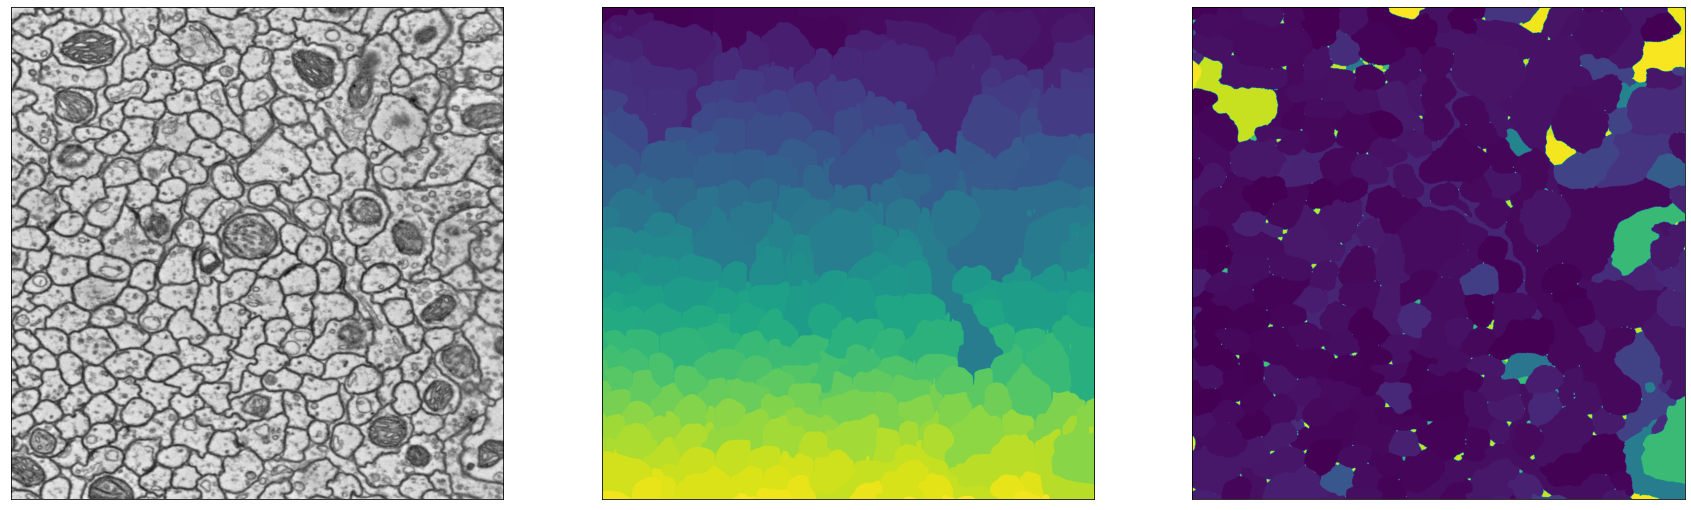

In [71]:
plt.figure(figsize=(30,20))
plt.subplot(131)
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[2]['image'][0],cmap="gray")

plt.subplot(132)
plt.xticks([])
plt.yticks([])
plt.imshow(total[2])

plt.subplot(133)
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[2]['segmentation'])

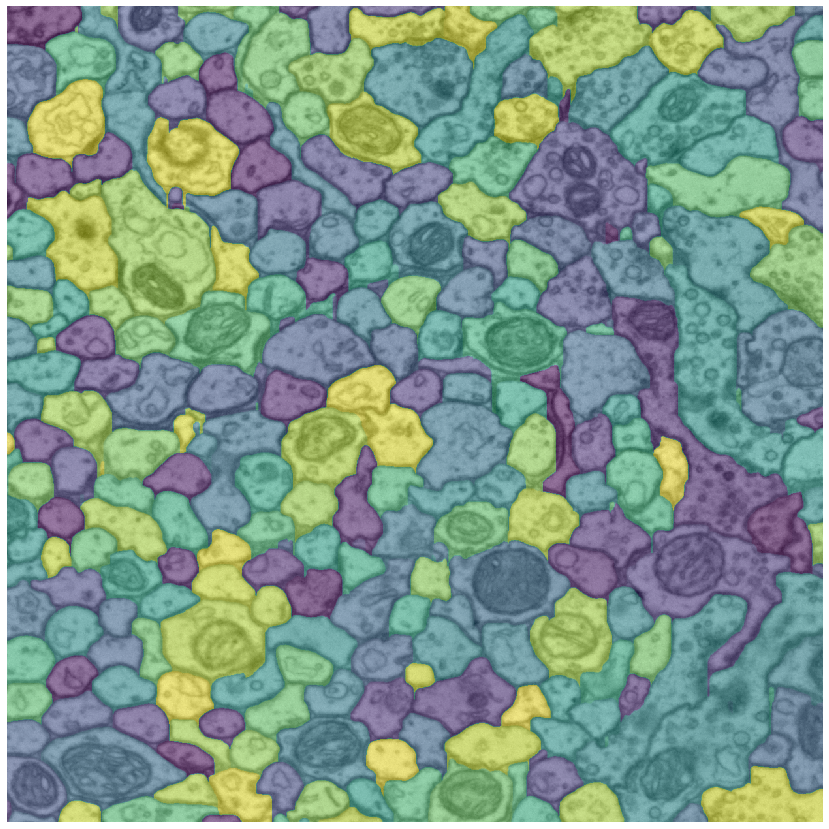

In [0]:
n = 0

labels = total[n].astype(np.uint64)
lut = np.unique(labels)
np.random.shuffle(lut)
lut[lut==lut[0]] = 12000
lut[0] = 0
colored = lut[labels-1]*5

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(dataset[n]['image'][0], cmap='gray',interpolation='none')
plt.imshow(colored,alpha=0.5)


In [0]:
from cremi import Annotations, Volume
from cremi.io import CremiFile

file = CremiFile("Results_final_test.hdf", "w")

# Write volumes representing the neuron segmentation.
neuron_ids = Volume(total, resolution=(40.0, 4.0, 4.0))
file.write_neuron_ids(neuron_ids)
file.close()